# 1. Import Libraries

In [1973]:
from Historic_Crypto import HistoricalData as HD
import pandas as pd
import requests
import json
import time
from datetime import datetime
import matplotlib.pyplot as plt
import scipy
import textwrap
import seaborn as sns

import scipy.stats
import numpy as np
from statistics import median, mean

# 2. Etherscan API Call

In [1974]:
def etherScanAPICall(wallet_address):
    API_KEY = 'JATAZ8XWIBGBTY15YJJEABCDPIF8SCK7S3'
    MATIC_CONTRACT_ADDRESS = '0x7D1AfA7B718fb893dB30A3aBc0Cfc608AaCfeBB0'
    # WALLET_ADDRESS = '0x9507c04b10486547584c37bcbd931b2a4fee9a41'
    url = 'https://api.etherscan.io/api?'

    parameters = {
        'module':'account',
        'action':'tokentx',
        'contractaddress':MATIC_CONTRACT_ADDRESS,
        'address':wallet_address,
        'page':'1',
        'offset':'10000',
        'startblock':'0',
        'endblock':'27025780',
        'sort':'asc',
        'apikey':API_KEY
    }

    responseJSON = requests.request("GET", url, params=parameters).json()

    print("# of Transactions:",len(responseJSON.get("result")))

    # with open("transactionsResponse.json", "w") as write_file:
    #     json.dump(responseJSON, write_file, indent=4, sort_keys = True)

    return responseJSON

In [1975]:
listOfWallets = [
    '0x9507c04b10486547584c37bcbd931b2a4fee9a41',
    '0x5666ed92c83af9dab61601c87bf7769ad57103f9',
    '0x7d1afa7b718fb893db30a3abc0cfc608aacfebb0',
    '0xed28b1c47375cd23aa6428544f4feaeaf3ee4e7b'
]

In [1976]:
def etherScanAPI_MultiWallet_Call(listOfWalletAddresses):

    totalTransactionDataList = []

    for wallet in listOfWalletAddresses:
        walletTransactionData = etherScanAPICall(wallet)
        totalTransactionDataList = totalTransactionDataList + walletTransactionData.get("result")

    return totalTransactionDataList

In [1977]:
rawTransactionData = etherScanAPI_MultiWallet_Call(listOfWallets)

# of Transactions: 2833
# of Transactions: 739
# of Transactions: 507
# of Transactions: 3


# 3. Create Dataframe of Transaction Data

In [1978]:
# Create a DataFrame from the list of dictionaries
rawTransactionData_df = pd.DataFrame(rawTransactionData)

rawTransactionData_df = rawTransactionData_df.sort_values("timeStamp")
rawTransactionData_df = rawTransactionData_df.reset_index(drop=True)

rawTransactionData_df = rawTransactionData_df.drop('nonce', axis=1)
rawTransactionData_df = rawTransactionData_df.drop('tokenName', axis=1)
rawTransactionData_df = rawTransactionData_df.drop('tokenDecimal', axis=1)
rawTransactionData_df = rawTransactionData_df.drop('input', axis=1)
rawTransactionData_df = rawTransactionData_df.drop('confirmations', axis=1)
rawTransactionData_df = rawTransactionData_df.drop('transactionIndex', axis=1)
rawTransactionData_df = rawTransactionData_df.drop('blockNumber', axis=1)
rawTransactionData_df = rawTransactionData_df.drop('hash', axis=1)
rawTransactionData_df = rawTransactionData_df.drop('blockHash', axis=1)
rawTransactionData_df = rawTransactionData_df.drop('gasUsed', axis=1)
rawTransactionData_df = rawTransactionData_df.drop('cumulativeGasUsed', axis=1)
rawTransactionData_df = rawTransactionData_df.drop('contractAddress', axis=1)

# Print the names of all the columns in the dataframe
print(rawTransactionData_df.columns)

Index(['timeStamp', 'from', 'to', 'value', 'tokenSymbol', 'gas', 'gasPrice'], dtype='object')


In [1979]:
# print(rawTransactionData_df.head())
# print(rawTransactionData_df.tail())

In [1980]:
# print(rawTransactionData_df.head()['timeStamp'])
# print("*******")
# print(rawTransactionData_df.tail()['timeStamp'])

# 4. Add Date Column to Dataframe

In [1981]:
def convert_UNIX_to_DateTime(unix):
    return datetime.utcfromtimestamp(int(unix)).strftime('%Y-%m-%d %H:%M:%S') # returns type str

In [1982]:
rawTransactionData_df.insert(1, 'date', 0)

for index, row in rawTransactionData_df.iterrows():
    date = convert_UNIX_to_DateTime(row["timeStamp"])[0:10]
    rawTransactionData_df.loc[index, "date"] = date


In [1983]:
# print(rawTransactionData_df.head()['date'])
# print("*******")
# print(rawTransactionData_df.tail()['date'])

# 5. Add Buy and Sell Column, Value Movement Column, and Total Gas Price Column

In [1984]:
rawTransactionData_df.insert(4, 'valueMovement', 0)
rawTransactionData_df.insert(5, 'tradeType', 0)

for index, row in rawTransactionData_df.iterrows():
    tradeType = "n/a"
    # considered a BUY
    if row["to"] in listOfWallets:
        valueMovement = int(row["value"])/(10**18)
        tradeType = "BUY"
    # considered a SELL
    elif row["from"] in listOfWallets:
        valueMovement = -1 * (int(row["value"])/(10**18))
        tradeType = "SELL"

    rawTransactionData_df.loc[index, "valueMovement"] = valueMovement
    rawTransactionData_df.loc[index, "tradeType"] = tradeType

rawTransactionData_df = rawTransactionData_df.drop('value', axis=1)

In [1985]:
rawTransactionData_df.insert(9, 'totalGasCost', 0)

for index, row in rawTransactionData_df.iterrows():

    totalGasCost = int(row['gas']) * int(row['gasPrice'])
    rawTransactionData_df.loc[index, "totalGasCost"] = totalGasCost

In [1986]:
# print(rawTransactionData_df["valueMovement"])
# print("*******")
# print(rawTransactionData_df["tradeType"])
# print("*******")
# print(rawTransactionData_df["totalGasCost"])

In [1987]:
# Output the DataFrame to a CSV file
rawTransactionData_df.to_csv('rawTransactionData_df.csv', index=True)

# Typecast Dataframe Data

In [1988]:
# convert the column to floats
rawTransactionData_df['timeStamp'] = rawTransactionData_df['timeStamp'].astype(float)
rawTransactionData_df['gas'] = rawTransactionData_df['gas'].astype(float)
rawTransactionData_df['gasPrice'] = rawTransactionData_df['gasPrice'].astype(float)

# 6. Get Start and End Date of Transaction Data

In [1989]:
# Get the first row of the dataframe
startDate_UNIX = rawTransactionData_df.loc[0, "timeStamp"]
# Get the last row of the dataframe
endDate_UNIX = rawTransactionData_df.loc[len(rawTransactionData_df.index)-1, "timeStamp"]

In [1990]:
# print("Start Date UNIX:", startDate_UNIX)
# print("End Date UNIX:", endDate_UNIX)

In [1991]:
startDate = str(convert_UNIX_to_DateTime(startDate_UNIX))[0:10]
endDate = str(convert_UNIX_to_DateTime(endDate_UNIX))[0:10]

In [1992]:
# print("Start Date:", startDate)
# print("End Date:", endDate)

In [1993]:
# Output the DataFrame to a CSV file
rawTransactionData_df.to_csv('rawTransactionData_df.csv', index=True)

# 7. Get Historical Crypto Data Price

In [1994]:
def getCryptoHistoricalData(token, startDate, endDate):
    data = HD(token,86400,startDate+"-00-00",endDate+"-00-00").retrieve_data()
    data.to_csv('tokenPriceData.csv')
    return data

In [1995]:
tokenPriceData_df = getCryptoHistoricalData("MATIC-USD", startDate, endDate)

Checking input parameters are in the correct format.
Formatting Dates.
Checking if user supplied is available on the CoinBase Pro API.
Connected to the CoinBase Pro API.
Ticker 'MATIC-USD' found at the CoinBase Pro API, continuing to extraction.
Provisional Start: 2019-08-07T00:00:00
Provisional End: 2020-06-02T00:00:00
Data for chunk 1 of 5 extracted
CoinBase Pro API did not have available data for 'MATIC-USD' beginning at 2019-08-07-00-00.  
                        Trying a later date:'2019-08-07T00:00:00'
Provisional Start: 2020-06-02T00:00:00
Provisional End: 2021-03-29T00:00:00
Data for chunk 2 of 5 extracted
Provisional Start: 2021-03-29T00:00:00
Provisional End: 2022-01-23T00:00:00


/Users/toddgavin/opt/anaconda3/lib/python3.9/site-packages/Historic_Crypto/HistoricalData.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(dataset)


Data for chunk 3 of 5 extracted
Provisional Start: 2022-01-23T00:00:00
Provisional End: 2022-11-19T00:00:00
Data for chunk 4 of 5 extracted
Provisional Start: 2022-11-19T00:00:00
Provisional End: 2023-09-15T00:00:00
Data for chunk 5 of 5 extracted


/Users/toddgavin/opt/anaconda3/lib/python3.9/site-packages/Historic_Crypto/HistoricalData.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(dataset)


In [1996]:
tokenPriceData_df = tokenPriceData_df.reset_index(drop=False)
print(tokenPriceData_df)

          time     low    high    open   close       volume
0   2021-03-11  0.3140  0.5900  0.3871  0.4243  226442305.9
1   2021-03-12  0.3924  0.5376  0.4249  0.4149  399949092.9
2   2021-03-13  0.4097  0.4694  0.4146  0.4249  173058984.7
3   2021-03-14  0.3727  0.4385  0.4263  0.3812  118930211.9
4   2021-03-15  0.3781  0.4300  0.3812  0.3909  115608670.0
..         ...     ...     ...     ...     ...          ...
638 2022-12-09  0.9080  0.9346  0.9278  0.9097   21652345.5
639 2022-12-10  0.9006  0.9165  0.9095  0.9084   14893056.2
640 2022-12-11  0.8885  0.9151  0.9085  0.8921   17559138.1
641 2022-12-12  0.8696  0.9130  0.8920  0.9111   25759143.9
642 2022-12-13  0.8795  0.9424  0.9112  0.9190   42046289.8

[643 rows x 6 columns]


In [1997]:
tokenPriceData_df.insert(1, 'date', 0)

for index, row in tokenPriceData_df.iterrows():
    date = str(row["time"])[0:10]
    tokenPriceData_df.loc[index, "date"] = date

tokenPriceData_df = tokenPriceData_df.drop('time', axis=1)


In [1998]:
print(tokenPriceData_df)

           date     low    high    open   close       volume
0    2021-03-11  0.3140  0.5900  0.3871  0.4243  226442305.9
1    2021-03-12  0.3924  0.5376  0.4249  0.4149  399949092.9
2    2021-03-13  0.4097  0.4694  0.4146  0.4249  173058984.7
3    2021-03-14  0.3727  0.4385  0.4263  0.3812  118930211.9
4    2021-03-15  0.3781  0.4300  0.3812  0.3909  115608670.0
..          ...     ...     ...     ...     ...          ...
638  2022-12-09  0.9080  0.9346  0.9278  0.9097   21652345.5
639  2022-12-10  0.9006  0.9165  0.9095  0.9084   14893056.2
640  2022-12-11  0.8885  0.9151  0.9085  0.8921   17559138.1
641  2022-12-12  0.8696  0.9130  0.8920  0.9111   25759143.9
642  2022-12-13  0.8795  0.9424  0.9112  0.9190   42046289.8

[643 rows x 6 columns]


In [1999]:
# datesList = list(tokenPriceData_df["time"])
datesToPriceDict = tokenPriceData_df.set_index('date')['open'].to_dict()

In [2000]:
# print(datesToPriceDict)

# 8. Orient dates across Historical Crypto Data and Transactions Data

In [2001]:
# Transactions Start and End Date
# print(startDate_UNIX)
# print(endDate_UNIX)

In [2002]:
startDate2 = str(tokenPriceData_df.loc[0, "date"]) + " 00:00:00"
# print(startDate2)

# Define a format string for the date and time
date_time_fmt = "%Y-%m-%d %H:%M:%S"
# Convert the string to a datetime object
startDate2 = datetime.strptime(startDate2, date_time_fmt)

# Print the datetime object
print(startDate2)

2021-03-11 00:00:00


In [2003]:
# convert the datetime object into a Unix timestamp
startDate2_UNIX = time.mktime(startDate2.timetuple())

# print(startDate_UNIX)
# print(startDate2_UNIX)

# The transactions start date is later than the crypto data start date
if int(startDate_UNIX) > int(startDate2_UNIX):
    startDate_main_UNIX = startDate_UNIX

# The transactions start date is earlier than the crypto data start date
else:
    startDate_main_UNIX = startDate2_UNIX

# print the Unix timestamp
# print(startDate_main_UNIX)

In [2004]:
endDate = tokenPriceData_df.loc[len(tokenPriceData_df.index)-1, "date"]
print(endDate)

2022-12-13


# 9. Match Datasets based on Date 

In [2005]:
rawTransactionData_df = rawTransactionData_df.drop(rawTransactionData_df.index[rawTransactionData_df.loc[:, 'timeStamp'] < startDate_main_UNIX])

rawTransactionData_df = rawTransactionData_df.reset_index(drop=True)

In [2006]:
# Output the DataFrame to a CSV file
rawTransactionData_df.to_csv('rawTransactionData_df.csv', index=True)

In [2007]:
print(rawTransactionData_df.head()["timeStamp"])

0    1.615709e+09
1    1.615762e+09
2    1.615894e+09
3    1.615894e+09
4    1.615947e+09
Name: timeStamp, dtype: float64


In [2008]:
print(len(rawTransactionData_df.index))
print(len(tokenPriceData_df.index))

4061
643


# Add MATIC Price Column, Total Cost USD column, and OHLC USD column to transactions Dataframe

In [2009]:
rawTransactionData_df.insert(7, 'priceUSD', 0)

for index, row in rawTransactionData_df.iterrows():
    # print("ran...")
    date = rawTransactionData_df.loc[index, "date"]
    # print("date:", date)
    dateRow_df = tokenPriceData_df.loc[tokenPriceData_df['date'] == date]
    # print("dateRow:\n", dateRow_df)
    dateRow_df = dateRow_df.reset_index(drop=True)
    price = (float(dateRow_df.loc[0, "open"]) + float(dateRow_df.loc[0, "close"]))/2
    # print("price:", price)

    rawTransactionData_df.loc[index, "priceUSD"] = price

In [2010]:
rawTransactionData_df.insert(8, 'totalCostUSD', 0)

for index, row in rawTransactionData_df.iterrows():

    totalCost = float(row["valueMovement"]) * float(row["priceUSD"])
    rawTransactionData_df.loc[index, "totalCostUSD"] = totalCost

In [2011]:
rawTransactionData_df.insert(9, 'OCdailyPriceMovementUSD', 0)
rawTransactionData_df.insert(10, 'HLdailyPriceMovementUSD', 0)

for index, row in rawTransactionData_df.iterrows():

    date = rawTransactionData_df.loc[index, "date"]

    maticPrice_df = tokenPriceData_df.loc[tokenPriceData_df['date'] == date]
    maticPrice_df = maticPrice_df.reset_index(drop=True)

    open = maticPrice_df.loc[0, "open"]
    close = maticPrice_df.loc[0, "close"]
    high = maticPrice_df.loc[0, "high"]
    low = maticPrice_df.loc[0, "low"]
    
    OCprice = open - close
    HLprice = high - low

    rawTransactionData_df.loc[index, "OCdailyPriceMovementUSD"] = OCprice
    rawTransactionData_df.loc[index, "HLdailyPriceMovementUSD"] = HLprice

In [2012]:
rawTransactionData_df = rawTransactionData_df.sort_values("timeStamp")
rawTransactionData_df = rawTransactionData_df.reset_index(drop=True)

In [2013]:
# Output the DataFrame to a CSV file
rawTransactionData_df.to_csv('rawTransactionData_df.csv', index=True)

# Create Transactions Volume Dataframe

In [2014]:
rawTransactionData_df['date'] = rawTransactionData_df['date'].astype(str)

In [2015]:
# Columns: -Index, #Date, *Num Transactions, *Value Movement, *Num BUYS, *Num Sells, *MATIC Price USD, -Total Cost USD, *OC daily price, *HL daily price

datesList = tokenPriceData_df['date'].to_list()
print(len(datesList))
print(datesList[0:5])

643
['2021-03-11', '2021-03-12', '2021-03-13', '2021-03-14', '2021-03-15']


In [2190]:
dateToDailyTransactionInfoDict = {}

for date in datesList:

    transaction_df = rawTransactionData_df.loc[rawTransactionData_df['date'] == date]
    transaction_df = transaction_df.reset_index(drop=True)

    # print("transaction_df\n", transaction_df, "\nend df...")

    if not transaction_df.empty:

        # loop through every row in the DataFrame and print the values
        for index, row in transaction_df.iterrows():

            valueMoved = row["valueMovement"]
            tradeType = row["tradeType"]

            if tradeType == "BUY":
                buy = 1
                sell = 0
            else: 
                sell = 1
                buy = 0

            if date not in dateToDailyTransactionInfoDict.keys():
                # print('run if..')
                dateToDailyTransactionInfoDict[date] = [1, valueMoved, buy, sell]

            # elif date in dateToDailyTransactionInfoDict.keys():
            else:
                # print('run elif..')
                currentTransactionInfo = dateToDailyTransactionInfoDict.get(date)

                currentNumTransactions = int(currentTransactionInfo[0]) + 1
                currentValueMoved = currentTransactionInfo[1] + valueMoved
                currentBuyNum = currentTransactionInfo[2] + buy
                currentSellNum = currentTransactionInfo[3] + sell

                dateToDailyTransactionInfoDict[date] = [currentNumTransactions, currentValueMoved, currentBuyNum, currentSellNum]

            # print(date, dateToDailyTransactionInfoDict.get(date))

    else:

        dateToDailyTransactionInfoDict[date] = [0, 0, 0, 0]

    # print(date, dateToDailyTransactionInfoDict.get(date))

In [2191]:
print(len(dateToDailyTransactionInfoDict))
# print(dateToDailyTransactionInfo)

643


In [2192]:
# create an empty list to store the lists
dateToDailyTransactionInfoList = []

# iterate over the dictionary's items and create a new list with the key as the first element and the value as the second element
for key, value in dateToDailyTransactionInfoDict.items():
    dateToDailyTransactionInfoList.append([key, value[0], value[1], value[2], value[3]])

In [2193]:
columnNames = ["date", "numTransactions", "valueMoved", "buyNum", "sellNum"]
timeSeriesTransactionData_df = pd.DataFrame(dateToDailyTransactionInfoList, columns=columnNames)

In [2194]:
print(timeSeriesTransactionData_df.head())

         date  numTransactions  valueMoved  buyNum  sellNum
0  2021-03-11                0         0.0       0        0
1  2021-03-12                0         0.0       0        0
2  2021-03-13                0         0.0       0        0
3  2021-03-14                2       552.0       2        0
4  2021-03-15                0         0.0       0        0


In [2195]:
# Output the DataFrame to a CSV file
timeSeriesTransactionData_df.to_csv('timeSeriesTransactionData_df.csv', index=True)

# Scatter Plot: Value Movement vs Total Gas Cost

In [2196]:
def create_scatter_plot(data1, data2):

    # plt.title("Chi Square Score vs ALT Frequency per SNP")
    # plt.xlabel("Chi Square Value")
    # plt.ylabel("ALT Frequency for SNP")

    # Use seaborn to plot the scatter plot
    sns.scatterplot(data1, data2)
    # Fit a regression line to the data and plot it on the scatter plot
    sns.regplot(data1, data2)

    # Show the plot
    plt.show()

In [2197]:
value_data = list(rawTransactionData_df['valueMovement'])
# Convert all items to positive floats
value_data = [float(abs(x)) for x in value_data]

totalGasCost_data = list(rawTransactionData_df['totalGasCost'])
gasPrice_data = list(rawTransactionData_df['gasPrice'])
maticPrice = list(rawTransactionData_df['priceUSD'])
totalCostValue = list(rawTransactionData_df['totalCostUSD'])
totalCostValue = [float(abs(x)) for x in totalCostValue]

In [2198]:
print(len(value_data))
print(len(totalGasCost_data))

# print(value_data)
# print(totalGasCost_data)

4061
4061


In [2199]:
# import numpy as np
# from scipy.stats import pearsonr

# # Calculate the Pearson correlation coefficient
# r, p = pearsonr(value_data, totalGasCost_data)

# print(r,p)

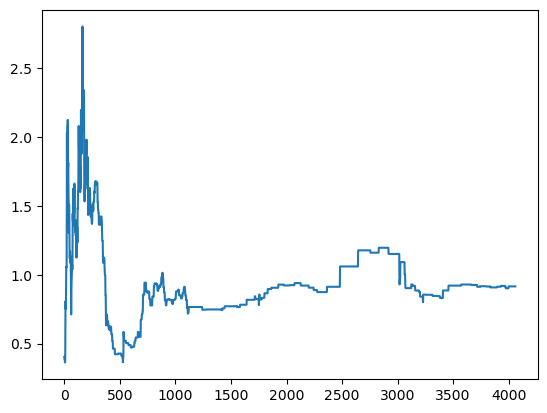

In [2200]:
plt.plot(maticPrice)

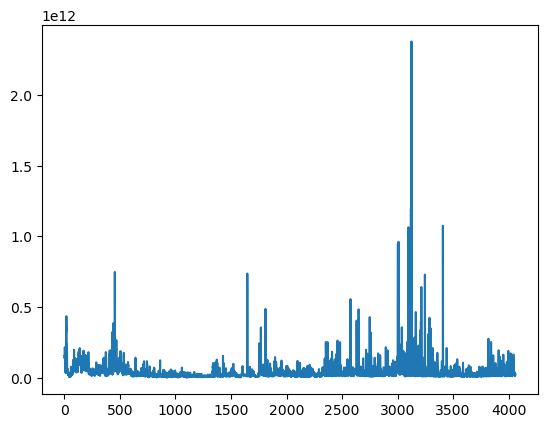

In [2201]:
plt.plot(gasPrice_data)

/Users/toddgavin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/toddgavin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


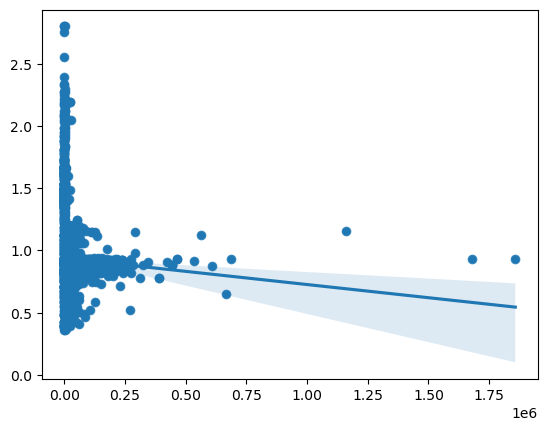

In [2202]:
create_scatter_plot(totalCostValue, maticPrice)

# `*********** END OF PROGRESS ***********`

# 5. Match Transactions Data to Crypto Historical Data 

In [2203]:
def getDailyTransactionVolumeForListOfWallets(transactionData):
    dailyTransactionVolume = {}

    for transaction in transactionData:
        timeStamp = convert_UNIX_to_DateTime(transaction.get("timeStamp"))
        timeStamp = timeStamp[0:10]
        if (timeStamp in dailyTransactionVolume):
            cnt = dailyTransactionVolume.get(timeStamp) + 1
            dailyTransactionVolume[timeStamp] = cnt
        else:
            dailyTransactionVolume[timeStamp] = 1


    ordered_data = sorted(dailyTransactionVolume.items(), key = lambda x:datetime.strptime(x[0],'%Y-%m-%d'), reverse=False)

    # print(type(ordered_data))
    # print(type(dict(ordered_data)))
    # print(dict(ordered_data))

    return dict(ordered_data)

In [2204]:
dailyTransactionVolume = getDailyTransactionVolumeForListOfWallets(rawTransactionData)

In [2205]:
# print(dailyTransactionVolume)

In [2206]:
rawTokenData = getCryptoHistoricalData('MATIC-USD', startDate, endDate)

Checking input parameters are in the correct format.
Formatting Dates.
Checking if user supplied is available on the CoinBase Pro API.
Connected to the CoinBase Pro API.
Ticker 'MATIC-USD' found at the CoinBase Pro API, continuing to extraction.
Provisional Start: 2019-08-07T00:00:00
Provisional End: 2020-06-02T00:00:00
Data for chunk 1 of 5 extracted
CoinBase Pro API did not have available data for 'MATIC-USD' beginning at 2019-08-07-00-00.  
                        Trying a later date:'2019-08-07T00:00:00'
Provisional Start: 2020-06-02T00:00:00
Provisional End: 2021-03-29T00:00:00
Data for chunk 2 of 5 extracted


/Users/toddgavin/opt/anaconda3/lib/python3.9/site-packages/Historic_Crypto/HistoricalData.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(dataset)


Provisional Start: 2021-03-29T00:00:00
Provisional End: 2022-01-23T00:00:00
Data for chunk 3 of 5 extracted
Provisional Start: 2022-01-23T00:00:00
Provisional End: 2022-11-19T00:00:00
Data for chunk 4 of 5 extracted
Provisional Start: 2022-11-19T00:00:00
Provisional End: 2023-09-15T00:00:00
Data for chunk 5 of 5 extracted


/Users/toddgavin/opt/anaconda3/lib/python3.9/site-packages/Historic_Crypto/HistoricalData.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(dataset)


In [2207]:
def getRangePrices(tokenData):
    highPrices = list(tokenData["high"])
    lowPrices = list(tokenData["low"])
    rangePrices = [a - b for a, b in zip(highPrices, lowPrices)]
     
    dateTimes = tokenData.index.tolist()

    datesToRangePrice = {}
    cnt = 0

    for dateTime in dateTimes:
        datesToRangePrice[str(dateTime)[0:10]] = rangePrices[cnt]
        cnt += 1

    # print(datesToRangePrice)
    return datesToRangePrice

In [2208]:
dailyTokenPriceAction = getRangePrices(rawTokenData)

In [2209]:
def alignTransactionsToPrice(transactions, prices):

    newTransactions = {}

    for key in prices.keys():
        if (key in transactions):
            newTransactions[key] = transactions.get(key)
        else:
            newTransactions[key] = 0

    # print(len(prices))
    # print(len(transactions))
    # print(len(newTransactions))
    # print(newTransactions)

    return newTransactions

In [2210]:
dailyTransactionVolume = alignTransactionsToPrice(dailyTransactionVolume, dailyTokenPriceAction)

In [2211]:
def createPlotFromDict(dict, title, x, y, description):
    keys = dict.keys()
    values = dict.values()

    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(y)
    # plt.figtext(0.5, -30, description, wrap=True, horizontalalignment='center', fontsize=10)

    # plt.bar(keys, values)
    plt.plot(keys, values)

    # add a description to the graph
    # text = textwrap.wrap(description, width=40)
    # plt.text(0, 20,'\n'.join(text), fontsize=10, ha='left', va='bottom')
    plt.figtext(0.5, -0.1, description, wrap=True, horizontalalignment='center', fontsize=12)

    # plots bar chart of keys (x) against values (y)
    plt.savefig(title+".png", dpi=300, bbox_inches = "tight")

In [2212]:
def printDataSet(data):
    print("Data Length:", len(data))
    print(str(data)+"\n")

In [2213]:
# printDataSet(dailyTransactionVolume)
# printDataSet(dailyTokenPriceAction)

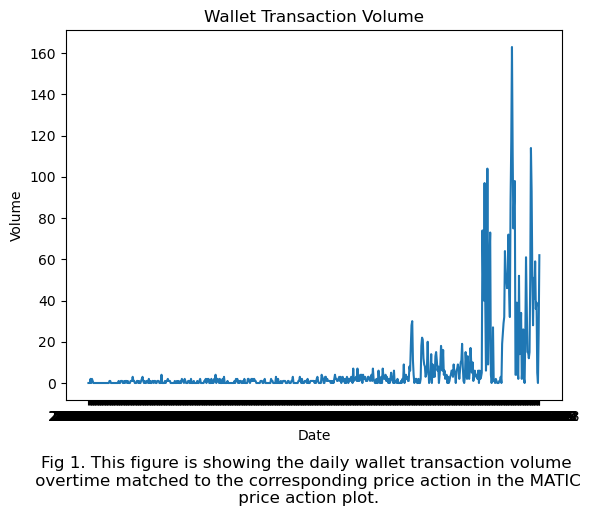

In [2214]:
createPlotFromDict(dailyTransactionVolume, "Wallet Transaction Volume", "Date", "Volume", "Fig 1. This figure is showing the daily wallet transaction volume\n overtime matched to the corresponding price action in the MATIC\n price action plot.")

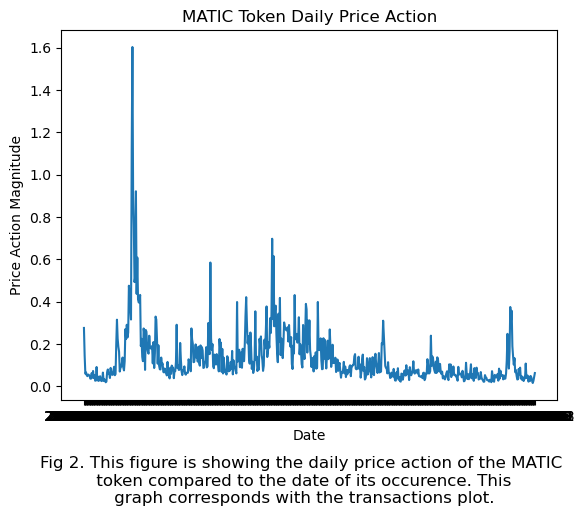

In [2215]:
createPlotFromDict(dailyTokenPriceAction, "MATIC Token Daily Price Action", "Date", "Price Action Magnitude", "Fig 2. This figure is showing the daily price action of the MATIC\n token compared to the date of its occurence. This\n graph corresponds with the transactions plot.")

In [2216]:
def performLinearRegression(data1, data2):
    a = list(data1.values())
    b = list(data2.values())

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(a, b)
    
    print("R_value:",r_value**2)
    print("P_value:",p_value)

In [2217]:
performLinearRegression(dailyTransactionVolume, dailyTokenPriceAction)

R_value: 0.012896821243707838
P_value: 0.003933735306894307


/Users/toddgavin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/toddgavin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

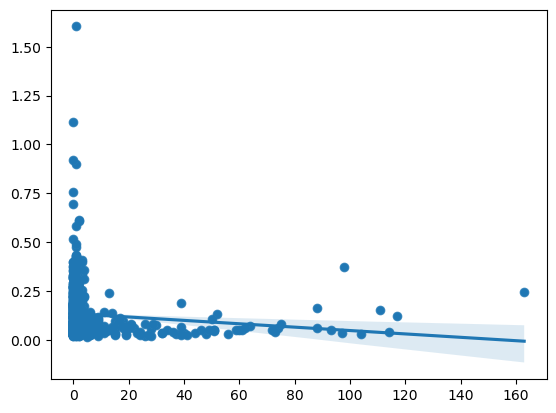

In [2218]:
import seaborn as sns

transactionVolume = list(dailyTransactionVolume.values())
tokenPriceAction = list(dailyTokenPriceAction.values())

# Create the scatter plot
sns.scatterplot(transactionVolume, tokenPriceAction)

# Add the linear regression line
sns.regplot(transactionVolume, tokenPriceAction)
